# Bruker meta data and raw ome-tiff preparation for preprocessing pipeline

Finds any .tif, .tiff, or ome.tiff files in the requested directory and first concatenates individual images into a single h5.

If the user collected analog recordings from the Bruker microscope, the user can set a flag to process those analog signals and extract event times.

If the user performed optogenetic stimulation (mark points), the user can set a flag to process the data and extract frame times where stimulation occurred as well as plot the mark points ROIs on the mean image.

** NOTE: Raw ome-tiff images from Bruker need to be in the root directory (fdir) along with any xml meta data files.


How to run this code
------------------------------------

__In this jupyter notebook, just run all cells in order (shift + enter). When you reach the last cell, it will prompt the user for input. You have two options:__

1) __Edit the parameters in define_params to analyze a single session:__ First make edits to the parameters in the __second cell of this notebook (in the define_params function)__. In the last line of the same cell, change the argument string argument for the __method parameter to 'single'__. Then run all the cells of this jupyter notebook in order (shift + enter).

2) You can also indicate specific files, parameters, and processing steps to include by __editing the python script called files_to_analyze_preprocess.py__ (in the same directory as this notebook). Follow the directions in that code; briefly you should first define the general parameters that will be applied to each session, then make additional dictionaries in the 'individual_files' list for each session to be analyzed. 
__A)__ Once you have specified the files and parameters in files_to_analyze_preprocess.py and saved the edits: In the last line of the 2nd cell of this notebook, change the argument string argument for the __method parameter to 'f2a'__
__B)__ Then execute all the cells in this notebook in order; this code will automatically load the information in files_to_analyze_preprocess.py.


Required Packages
-----------------
Python 2.7, scipy, h5py, multiprocessing, matplotlib, PIL, tifffile, lxml, pandas

Custom code requirements: bruker_marked_pts_process, files_to_analyze_preprocess, utils_bruker

Parameters (Only relevant if using the subfunction batch_process; ignore if using files_to_analyze or using default params by inputting a file directory)
----------

fname : string
    name the session

fdir : string
    root file directory containing the raw ome-tiff files. Note: leave off the last backslash. For example: r'C:\Users\my_user\analyze_sessions'

Optional Parameters
-------------------

#### parameters for stitching bruker ome-tiffs to h5/tiffstack
flag_make_h5_tiff : boolean  
  * set as true if ome-tiffs need to be concatenated into an h5
  
save_type: string  
  * Set as 'h5' or 'tif'

number_frames: None or int  
  * Optional; number of frames to analyze; defaults to analyzing whole session (None)

flag_bruker_analog: boolean
  * Set to true if analog/voltage input signals are present and are of interest
  
flag_bruker_stim : boolean
  * Set to true if mark points SLM stim was performed
  
#### General analog processing variables
analog_names : list of strings
  * Strings should correspond to the TTL names for each analog channel; will replace default channel names based on numbering

analog_ttl_thresh : int/float
  * Threshold value for detecting TTL onsets in analog data; The diff/velocity is calculated, peaks that cross this threshold are counted as event onsets 

flag_validation_plots : boolean 
  * Set to true if want to plot traces of ttl pulses for visualizing and validating. Channel to plot is valid_plot channel
  
valid_plot_channel : string  
  * Analog dataframe column names get cleaned up; AI's are "input_#"
                
flag_multicondition_analog : boolean
  * Set to true if a single analog channel contains multiple conditions
  
  defaults to False
  
ai_to_split : int  
  * analog port number that contains TTLs of multiple conditions; events here will be split into individual conditions if flag_multicondition_analog is set to true

behav_id_of_interest: list of strings/ints
  * Entries of this list must correspond to IDs used in the excel matching event names and id's (key_event.xlsx). eg. [101,102,103]
  
flag_plot_stim_threshold: Boolean
  * Set to true to detect frames during which optogenetic stimulation occurred (useful for setting stimmed frames to NaN if there are stim artifacts

flag_plot_stim_locs: Boolean
  * Set to true to save a plot of the mean projection image with stimulation location contours overlaid
  
stim_frame_threshold: int/float
  * Stimmed frames from opto are detected based on frame-averaged pixel values. Since stimmed frames have blanked lines, pixel-averaged fluorescence should be low. This is the threshold in std dev below mean for detecting stimmed frames via pixel-avged fluorescence (works if pmt is blanked during stim).
    
Output
-------
motion corrected file (in the format of h5) with "\_sima_mc" appended to the end of the file name

"\*\_.h5" : h5 file
  * h5 file containing imaging frame data under the key 'imaging'

"\framenumberforevents_*\_.pkl" : pickle file
  * Only outputted if flag_bruker_analog is set to True
  * pickle file containing dict with trial conditions as keys and lists of frame times for each event as values
  
"\*\_stimmed_frames.pkl" : pickle file
  * Only outputted if flag_bruker_stim is set to True
  * pickle file containing a dict. Keys are 'samples' and 'times' which contain numpy arrays listing the samples/times where stimulation occurred

"\*.json" : json file
  * file containing the analysis parameters (fparams). Set by files_to_analyze_preprocess.py or default parameters.
  * to view the data, one can easily open in a text editor (eg. word or wordpad).

output_images : folder containing images  
    You will also find a folder containing plots that reflect how each executed preprocessing step performed. Examples are mean images for motion corrected data, ROI masks overlaid on mean images, extracted signals for each ROI, etc..

note: * is a wildcard indicating additional characters present in the file name

In [1]:
#### packages for raw video to h5 processing
import numpy as np
import pandas as pd
import os
import glob
import json
import warnings
import time

# pip-installed packages
from scipy import signal
import h5py
import multiprocessing as mp
import matplotlib.pyplot as plt
from PIL import Image
from PIL.TiffTags import TAGS
import tifffile as tiff
from lxml.html.soupparser import fromstring
from lxml.etree import tostring

# custom code
import bruker_marked_pts_process
import files_to_analyze_preprocess

#### more packages for xml meta and analog input processing
import pickle
import re
import xml.etree.ElementTree as ET
import pandas as pd

# custom code
import utils_bruker

In [2]:
"""

User-defined variables

"""


def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z


def define_params(method = 'single'):
    
    fparams = {}
    
    if method == 'single':
        
        fparams = [
            {
                # ONLY EDIT LINES BELOW THIS COMMENT (parameters for analyzing a single session)
                
                # parameters for stitching bruker ome-tiffs to h5/tiffstack
                'fname': 'zstim_-388_0um-011',   # 
                'fdir':  r'D:\bruker_data\Charles\pl_imageactivate_02_zstim_param_20210225\zstim_-388_0um-011', #  
                'save_type': 'h5',
                'number_frames': None, # optional; number of frames to analyze; defaults to analyzing whole session (None)
                
                # flags for performing the main sub-analyses
                'flag_make_h5_tiff': True,
                'flag_bruker_analog': True, # set to true if analog/voltage input signals are present and are of interest
                'flag_bruker_stim': False, # set to true if mark points SLM stim was performed

                # general analog processing variables
                'analog_names': ['stim', 'frames', 'licks', 'rewards'],
                'analog_ttl_thresh': 0.05, # threshold in voltage to detect TTL onset
                # variables for plotting TTL pulses
                'flag_validation_plots': True, # set to true if want to plot traces of ttl pulses for visualizing and validating
                'valid_plot_name': 'stim', # analog dataframe column names get cleaned up; AI's are "input_#"
                
                # variables for splitting analog channels encoding multiple conditions
                'flag_multicondition_analog': False,
                'ai_to_split': 2, # int, analog port number that contains TTLs of multiple conditions; events here will be split into individual conditions if flag_multicondition_analog is set to true
                'behav_id_of_interest': [101,102,103],
                # generate trial condition name list for whole session (for parameterization session)
                'flag_parameterization_session': True,
                'trial_condition_list': ['30_reps', '10_reps', '20_reps', '40_reps'] * 3,

                # variables for stimulation detection
                'flag_plot_stim_threshold': True, # boolean to plot the 2p pixel-avg tseries with threshold for detecting stimmed blank frames
                'flag_plot_stim_locs': True,
                'stim_frame_threshold': 1 # threshold in std dev below mean for detecting stimmed frames via pixel-avged fluorescence (works if pmt is blanked during stim)
                
                # ONLY EDIT LINES ABOVE THIS COMMENT
            }
        ]
        
    elif method == 'f2a': # if string is empty, load predefined list of files in files_to_analyze_event

        fparams_with_general = files_to_analyze_preprocess.define_fparams()
        # lines below merge general params for each individual session to analyze
        # merge_two_dicts: variables existing in 2nd arg are retained
        fparams = [merge_two_dicts(fparams_with_general['general_params'], this_file_dict) 
                   for this_file_dict in fparams_with_general['individual_files']]
    
    elif method == 'csv':
        
        # easier to load the csv to dataframe then convert to dict
        fparams=pd.read_csv('files_to_analyze_prepreprocess.csv').to_dict('record') 
        
        # lists get loaded in as strings, so these are the keys that contain strings that need to be executed to form lists
        eval_keys = ['analog_names', 'trial_condition_list', 'behav_id_of_interest', 'number_frames']
        for idx, fparam in enumerate(fparams):
            for eval_key in eval_keys:
                if eval_key in fparam and isinstance(fparam[eval_key], str) :
                    fparam[eval_key] = eval(fparam[eval_key])
            fparams[idx] = fparam
    
    elif method == 'root_dir':
        
        pass
    
    return fparams

# USER CAN EDIT LINE BELOW THIS COMMENT TO CHANGE SESSION DEFINING METHOD
fparams = define_params(method = 'single') # options are 'single', 'f2a', 'root_dir', 'csv'

### Functions for loading in meta data

In [3]:
# ome-tiff contains meta data - read this in 
def get_tif_meta(tif_path):
    meta_dict = {}
    # iterate through metadata and create dict for key/value pairs
    with Image.open(tif_path) as img:
        for key in img.tag.iterkeys():
            if key in TAGS:
                meta_dict[TAGS[key]] = img.tag[key] 
            else:
                meta_dict[key] = img.tag[key] 
    
    return meta_dict


# load in recording/tseries main xml and grab frame period
def bruker_xml_get_2p_fs(xml_path):
    xml_parse = ET.parse(xml_path).getroot()
    for child in list(xml_parse.findall('PVStateShard')[0]):
        if 'framePeriod' in ET.tostring(child):
            return 1.0/float(child.attrib['value'])
        

def make_imaging_info_df(bruker_tseries_xml_path):
    xml_parse = ET.parse(bruker_tseries_xml_path).getroot()
    frame_info_df = pd.DataFrame()
    type_tags = xml_parse.findall('Sequence/Frame')

    # lambda function to take in a list of xml frame meta data and pull out timing and cycle info 
    grab_2p_xml_frame_time = lambda type_tag: [float(type_tag.attrib['relativeTime']), 
                                               float(type_tag.attrib['absoluteTime']),
                                               int(re.findall('Cycle(\d+)', type_tag.findall('File')[0].attrib['filename'])[0]), # first grab this frame's file name, then use regex to grab cycle number in the fname
                                               float(type_tag.attrib['index']),
                                              ] 

    # make a dataframe of relative time, absolute time, cycle number for each frame
    imaging_info_df = pd.DataFrame(map(grab_2p_xml_frame_time, type_tags), columns=['rel_time', 'abs_time', 'cycle_num', 'index'])

    return imaging_info_df


# load 2p recording meta xml and extract the info into a dict
def bruker_make_2p_meta_dict(fdir, fname, paths_dict):
    meta_2p_dict = {}
    meta_2p_dict['fs_2p_single_frame'] = bruker_xml_get_2p_fs(paths_dict['bruker_tseries_xml_path'])
    # extract frame timing and cycle info into a pandas dataframe 
    meta_2p_dict['imaging_info_df'] = make_imaging_info_df(paths_dict['bruker_tseries_xml_path'])
    
    # Parse main 2p time-series xml
    meta_2p_dict['tvec_2p'] = meta_2p_dict['imaging_info_df']['rel_time']
    meta_2p_dict['num_frames_2p'] = len(meta_2p_dict['tvec_2p'])
    meta_2p_dict['recording_type'] = bruker_xml_get_recording_type(paths_dict['bruker_tseries_xml_path'])
    return meta_2p_dict

### functions for raw video conversion to h5

In [4]:
# to save json of manual params
def save_json_dict(savedir, fname, dict_):

    savepath = os.path.join(savedir, fname + '.json')

    with open(savepath, 'w') as fp:
        json.dump(dict_, fp)


def read_shape_tiff(data_path):
    
    data = uint16_scale(tiff.imread(data_path)).astype('uint16')
    data_shape = data.shape

    return data, data_shape


def get_ometif_xy_shape(fpath):
    # read first tiff to get data shape
    first_tif = tiff.imread(fpath, key=0, is_ome=True)
    return first_tif.shape


def assert_bruker(fpath):
    meta_dict = get_tif_meta(fpath)
    assert ('Prairie' in meta_dict['Software'][0]), "This is not a bruker file!"
    

# function to load individual ome-tiffs and add them to the tif-stack or h5 handle
def load_save_composite_frames(save_object, glob_list, chunked_frame_idx, save_format):
    # go through each chunk, load frames in chunk, process, and append to file
    for idx, chunk_frames in enumerate(chunked_frame_idx):
        print( 'Processing chunk {} out of {} chunks'.format(str(idx+1), str(len(chunked_frame_idx))) )
        start_idx = chunk_frames[0]
        end_idx = chunk_frames[-1]+1

        data_to_save = tiff.imread(glob_list[start_idx:end_idx], key=0, is_ome=True)

        if save_format == 'tif':

            for frame in data_to_save:
                save_object.save(frame, photometric='minisblack')

        # https://stackoverflow.com/questions/25655588/incremental-writes-to-hdf5-with-h5py
        elif save_format == 'h5':   

            # append data to h5    
            save_object[start_idx:end_idx] = data_to_save

            
# main function to prepare list of ome-tiffs in directory and handles for stacking the tiffs            
def main_ometif_to_composite(fdir, fname, save_type='h5', num_frames=None):

    save_fname = os.path.join(fdir, fname)
    glob_list = sorted(glob.glob(os.path.join(fdir,"*.tif")))
    
    # get frame info
    if not num_frames: 
        num_frames = len(glob_list)
    frame_shape = get_ometif_xy_shape(glob_list[0])
    print(str(num_frames) + ' total frame(s)')

    # prepare to split data into chunks when loading to reduce memory imprint
    chunk_size = 10000.0
    n_chunks = int(np.ceil(num_frames/chunk_size))
    chunked_frame_idx = np.array_split(np.arange(num_frames), n_chunks) # split frame indices into chunks

    assert_bruker(glob_list[0])
    print('Processing Bruker data')

    # prepare handles to write data to
    if save_type == 'tif':
        save_object = tiff.TiffWriter(save_fname + '.tif', bigtiff=True)
    elif save_type == 'h5':
        f = h5py.File(save_fname + '.h5', 'w')
        # get data shape and chunk up data, and initialize h5 
        save_object = f.create_dataset('imaging', (num_frames, frame_shape[0], frame_shape[1]), 
                                maxshape=(None, frame_shape[0], frame_shape[1]), dtype='uint16')
        
    load_save_composite_frames(save_object, glob_list, chunked_frame_idx, save_type)
    
    if save_type == 'h5':
        f.close()

### functions for meta data xml processing and analog processing

In [5]:
# make a dict of possible paths for loading and saving
def bruker_analog_define_paths(fdir, fname):
    paths_dict = {'fdir': fdir, 'fname': fname}
    paths_dict['bruker_tseries_xml_path'] = os.path.join(fdir, fname + '.xml') # recording/tseries main xml
    paths_dict['glob_analog_csv'] = glob.glob(os.path.join(fdir,"*_VoltageRecording_*.csv")) # grab all analog/voltage recording csvs
    paths_dict['glob_analog_xml'] = glob.glob(os.path.join(fdir,"*_VoltageRecording_*.xml")) # grab all analog/voltage recording xml meta
    # behavioral event identification files
    paths_dict['behav_fname'] = fname + '_taste_reactivity.csv' # csv containing each behav event and corresponding sample
    paths_dict['behav_event_key_path'] = r'D:\bruker_data\Adam\key_event.xlsx' # location of excel matching event names and id's
    # define save paths
    paths_dict['fig_out_dir'] = os.path.join(fdir, '{}_output_images'.format(fname) )
    paths_dict['behav_save_path_no_ext'] = os.path.join(fdir, 'framenumberforevents_{}'.format(fname) )
    paths_dict['behav_analog_save_path_no_ext'] = os.path.join(fdir, 'framenumberforevents_analog_{}'.format(fname) )
     
    return paths_dict


# simple function to go into tseries xml and grab recording type (important for distinguishing tseries with z-stacks)
bruker_xml_get_recording_type = lambda xml_path_in: ET.parse(xml_path_in).getroot().findall('Sequence')[0].get('type')


# loads and parses the analog/voltage recording's xml and grabs sampling rate
def bruker_analog_xml_get_fs(xml_fpath):
    analog_xml = ET.parse(xml_fpath).getroot()
    return float(analog_xml.findall('Experiment')[0].find('Rate').text)


"""
Concatenate the analog input csv files if there are multiple cycles. Also make a dataframe with the 
raw analog tseries and thresholded tseries (for ttl onset detection)
""" 
def bruker_concatenate_thresh_analog(fparams):
    # grab all csv voltage recording csv files that aren't the concatenated full
    glob_analog_csv = [f for f in glob.glob(os.path.join(fparams['fdir'],"*_VoltageRecording_*.csv")) if 'concat' not in f]
    glob_analog_xml = glob.glob(os.path.join(fparams['fdir'],"*_VoltageRecording_*.xml"))

    if not glob_analog_csv:
        print('No analog csv detected or \'concat\' is in the name ')
    
    # xml's contain metadata about the analog csv; make sure sampling rate is consistent across cycles
    analog_xml_fs = set(map(bruker_analog_xml_get_fs, glob_analog_xml)) # map grabs sampling rate across all cycle xmls; set finds all unique list entries  
    if len(analog_xml_fs) > 1: 
          warnings.warn('Sampling rate is not consistent across cycles!')
    else:
        analog_fs = list(analog_xml_fs)[0]
    
    # cycle through analog csvs and append to a dataframe
    analog_concat = pd.DataFrame()
    for cycle_idx, cycle_path_csv in enumerate(glob_analog_csv):

        cycle_df = pd.read_csv(cycle_path_csv)
        num_samples = len(cycle_df['Time(ms)'])
        cycle_df['Time(s)'] = cycle_df['Time(ms)']/1000.0

        cycle_df['cycle_num'] = float(re.findall('Cycle(\d+)', cycle_path_csv)[0]) # get cycle # from filename
        if cycle_idx == 0: # initialize pd dataframe with first cycle's data
            cycle_df['cumulative_time_ms'] = cycle_df['Time(ms)'].values
            analog_concat = cycle_df
        else:
            # since time resets for each cycle (if more than one), calculate cumulative time
            last_cumulative_time = analog_concat['cumulative_time_ms'].iloc[-1]
            cycle_df['cumulative_time_ms'] = cycle_df['Time(ms)'].values + last_cumulative_time + 1 # add 1 so that new cycle's first sample isn't the same as the last cycle's last sample
            analog_concat = analog_concat.append(cycle_df, ignore_index = True)
    
    # clean up column names
    analog_concat.columns = analog_concat.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '_').str.replace(')', '')
        
    # loop through all analog columns and get the diff and threshold for event onsets
    analog_column_names = [column for column in analog_concat.columns if 'input' in column]
    num_analogs = len(analog_column_names)   
    for idx, analog_column_name in enumerate(analog_column_names):
        
        ttl_thresh = fparams['analog_ttl_thresh']
        if 'stim' in fparams['analog_names']: 
            if idx == fparams['analog_names'].index('stim'):
                ttl_thresh = 0.05
            
                
        print(analog_column_name)
        print(ttl_thresh)
        analog_concat[analog_column_name + '_diff'] = np.append(np.diff(analog_concat[analog_column_name]) > ttl_thresh, 
                                                                False) # add a false to match existing df length

    # save concatenated analog csv        
    save_full_csv_path = os.path.join(fparams['fdir'], fparams['fname'] + '_VoltageRecording_concat.csv')
    analog_concat.to_csv(save_full_csv_path, index=False)

    return analog_concat


# function for finding the index of the closest entry in an array to a provided value
def find_nearest_idx(array, value):

    if isinstance(array, pd.Series):
        idx = (np.abs(array - value)).idxmin()
        return idx, array.index.get_loc(idx), array[idx] # series index, 0-relative index, entry value
    else:
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx, array[idx]


"""
Take in analog dataframe (contains analog tseries and thresholded boolean) and 
make dict of 2p frame times for each condition's event
""" 
def match_analog_event_to_2p(meta_2p_dict, imaging_info_df, analog_dataframe, rename_ports = None, flag_multicondition_analog = False): 
    
    analog_event_dict = {} # will contain analog channel names as keys and 2p imaging frame numbers for each event/ttl onset
    analog_event_samples = {}
    all_diff_columns = [diff_column for diff_column in analog_dataframe.columns if 'diff' in diff_column] # grab all diff'd analog column names
    
    if rename_ports:
        if len(rename_ports) != len(all_diff_columns):
            warnings.warn('Number of ports to rename doesn\'t match with actual number of ports! Only renaming available number of ports')
    
    for ai_diff in sorted(all_diff_columns):
        
        # if user gives ports to rename, grab port data name
        if rename_ports:
            ai_port_num = int(re.findall('\d+', ai_diff )[0])
            if ai_port_num < len(rename_ports):
                ai_name = rename_ports[ai_port_num]
        else:
            ai_name = ai_diff
        
        if flag_multicondition_analog: # if the trials in analog ports need to be split up later, make a subdict to accommodate conditions keys
            analog_event_dict[ai_name] = {}; analog_event_dict[ai_name]['all'] = []
            analog_event_samples[ai_name] = {}; analog_event_samples[ai_name]['all'] = []
        else:
            analog_event_dict[ai_name] = []
            analog_event_samples[ai_name] = [] 
            
        # grab analog samples where TTL onset occurred
        # analog_df diff columns are booleans for each frame that indicate if TTL threshold crossed (ie. event occurred)
        analog_events = analog_dataframe.loc[analog_dataframe[ai_diff] == True, ['time_s', 'cycle_num']] 

        # for each detected analog event, find nearest 2p frame index and add to analog event dict
        for idx, analog_event in analog_events.iterrows():
            
            if 'TSeries ZSeries' in meta_2p_dict['recording_type']:
                this_cycle_imaging_info = imaging_info_df # each zseries full acquisition increments cycle, but for etl imaging, we don't want to separate the df into cycles
            else:
                this_cycle_imaging_info = imaging_info_df[imaging_info_df['cycle_num'] == analog_event['cycle_num']]
            
            whole_session_idx, cycle_relative_idx, value = find_nearest_idx(this_cycle_imaging_info['rel_time'], analog_event['time_s'])

            if flag_multicondition_analog:
                analog_event_dict[ai_name]['all'].append(whole_session_idx)
                analog_event_samples[ai_name]['all'].append(idx)
            else:
                analog_event_dict[ai_name].append(whole_session_idx)
                analog_event_samples[ai_name].append(idx)
                
        analog_event_dict[ai_name]= sorted(list(set(analog_event_dict[ai_name])))
        analog_event_samples[ai_name] = sorted(list(set(analog_event_samples[ai_name])))
        
    return analog_event_dict, analog_event_samples

    
"""
if all behav events of interest (different conditions) are recorded on a single AI channel
and need to reference the behavioral events csv to split conditions up
""" 
def split_analog_channel(ai_to_split, behav_id_of_interest, fdir, behav_fname, behav_event_key_path, analog_event_dict, plane_idx):

    unicode_to_str = lambda x:str(x) # just a simple function to convert unicode to string; 

    this_ai_to_split = [analog_diff_name for analog_diff_name in analog_event_dict.keys() if str(ai_to_split) in analog_diff_name][0]
    
    # load id's and samples (camera samples?) of behavioral events (output by behavioral program)
    behav_df = pd.read_csv(os.path.join(fdir, behav_fname), names=['id', 'sample'])
    behav_event_keys = pd.read_excel(behav_event_key_path)

    # using the behav event id, grab the event name from the keys dataframe; names are in unicode, so have to convert to string
    behav_name_of_interest = map(unicode_to_str, 
                                 behav_event_keys[behav_event_keys['event_id'].isin(behav_id_of_interest)]['event_desc'].values)

    # go into ordered behavioral event df, grab the trials with condition IDs of 'behav_id_of_interest' in order
    trial_ids = list(behav_df[behav_df['id'].isin(behav_id_of_interest)]['id'].values) # grab 101, 102, 103 trials in order
    
    # loop through behav conditions, and separate event times for the conglomerate event times in analog_event_dict
    for behav_event_id, behav_event_name in zip(behav_id_of_interest, behav_name_of_interest):
        this_event_idxs = [idx for idx,val in enumerate(trial_ids) if val==behav_event_id]
        analog_event_dict[this_ai_to_split][behav_event_name] = [analog_event_dict[this_ai_to_split]['all'][idx] for idx in this_event_idxs]
        # analog_event_dict ultimately contains 2p frame indices for each event categorized by condition

    # save preprocessed behavioral event data
    with open(behav_analog_save_path, 'wb') as handle:
        pickle.dump(analog_event_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

        
# two funtions below aid in splitting the stim channel for the specific stim parameterization session made by CZ
def find_param_stim_bout_onsets(event_dict, fs):
    
    # finds stim frames that come after an inter-pulse interval of 5 s (ie. the start pulse of a trial)
    event_frames = [event_dict['stim'][idx+1] for (idx,val) in enumerate(np.diff(event_dict['stim'])) if val > fs*5  ]
    event_frames = [event_dict['stim'][0]] + event_frames # add the first pulse of the session (first trial)
    event_dict.pop('stim', 'none'); # get rid of 'stim' key in dict that contains all conditions; no longer useful
    event_dict['stim_trial_onset'] = event_frames
    
    return event_dict 


def split_event_dict_key(event_name_list, event_dict):

    # create empty lists for each new trial condition (key)
    for key in set(event_name_list):
        event_dict[key] = []
                                                        
    # loop through trial cond list (must match length of start_stim_frames), and sort trials in dict
    for idx, cond in enumerate(event_name_list):
        event_dict[cond].append(event_dict['stim_trial_onset'][idx])

    return event_dict

    
# take in data from an analog input and plot detected ttls
def plot_analog_validation(AI_onsets, analog_tseries, analog_fs, thresh, save_dir = None):
    # following is just for visualizing ttls; here make tiles for indexing and extracting ttl data in trial manner
    num_AI = len(AI_onsets)
    
    if num_AI > 1:
    
        rel_ind_vec = np.arange(-0.3*analog_fs, 1*analog_fs, 1)
        trial_tvec = np.linspace(-0.3, 1, len(rel_ind_vec))
        rel_ind_tile = np.tile(rel_ind_vec, (num_AI,1))
        AI_onset_tile = np.tile(AI_onsets, (len(rel_ind_vec),1)).T

        # extract analog values across flattened trial indices, get values of series, then reshape to 2d array
        AI_value_tile = analog_tseries[np.ndarray.flatten(AI_onset_tile + rel_ind_tile)].values.reshape(AI_onset_tile.shape)
        if AI_value_tile.shape[0] == num_AI:
            AI_value_tile = AI_value_tile.T

        fig, ax = plt.subplots(1,2,figsize=(13,5))

        ax[0].set_title('Full TTL series')
        ax[0].plot(analog_tseries)
        ax[0].plot(np.ones(len(analog_tseries))*thresh)

        ax[1].set_title('{} ttls detected'.format(num_AI))
        ax[1].plot(trial_tvec, AI_value_tile );
        ax[1].set_xlabel('Time (s)')
        ax[1].set_ylabel('Volts');

    #     svec = np.arange(0, 15*analog_fs)
    #     tvec_plot = svec/analog_fs
    #     ax[2].set_title('Specific window (first 15s)')
    #     ax[2].plot(tvec_plot, analog_tseries[svec])
    #     ax[2].set_xlabel('Seconds')

        if save_dir:
            utils_bruker.check_exist_dir(save_dir)
            fig.savefig(os.path.join(save_dir, 'ttl_validation.png'));


# see description below: performs main lifting of analog data processing
def bruker_process_analog_ttl(fparams, paths_dict, meta_2p_dict):
    
    """
    If you have analog signals, that indicate behavioral event onset, sent from your behavioral DAQ to the bruker GPIO box, the following code:

    1) parses the analog voltage recording xmls 
    2) extracts the signals from the csvs
    3) extracts the TTL onset times
    4) and finally lines up which frame the TTL occurred on.
    """
    
    ### get analog data sampling rate from xml
    analog_fs = bruker_analog_xml_get_fs(paths_dict['glob_analog_xml'][0])

    ### either load concatenated voltage recording (across cycles), perform the concatenation, or load a single CSV (for single cycle)
    volt_rec_full_path = os.path.join(fparams['fdir'], fparams['fname'] + '_VoltageRecording_concat.csv')
    if os.path.exists(volt_rec_full_path): # if a trial-stitched, thresholded voltage recording was previously saved
        print('Analog processing: Loading previous concatenated analog tseries')
        analog_df = pd.read_csv(volt_rec_full_path)
    else:
        print('Analog processing: Processing analog tseries')
        analog_df = bruker_concatenate_thresh_analog(fparams) 
    
    # tmp CZ - probably not the best way to switch between multiplane and single plane:
    if 'TSeries ZSeries' in meta_2p_dict['recording_type']:
        planes_2_analyze = meta_2p_dict['imaging_info_df']['index'].unique()
    else:
        planes_2_analyze = [1.0] # just a placeholder to make next loop happen once
    
    # imaging_info_df index column indicates z plane index; loop through analyzing each plane
    for plane_idx in planes_2_analyze:

        # tmp CZ - probably not the best way to switch between multiplane and single plane:
        if 'TSeries ZSeries' in meta_2p_dict['recording_type']:
            # grab frame timing for relevant plane
            imaging_info_df_plane = meta_2p_dict['imaging_info_df'][meta_2p_dict['imaging_info_df']['index']==plane_idx].reset_index(drop=True)
        else:
            imaging_info_df_plane = meta_2p_dict['imaging_info_df']
        meta_2p_dict['fs_2p'] = 1/np.mean(np.diff(imaging_info_df_plane['rel_time']))
        
        ### match analog ttl event onsets to the corresponding 2p frame (for each event in each analog port)
        print('Analog processing: match event sample to 2p frame')
        analog_event_dict, analog_event_samples = match_analog_event_to_2p(meta_2p_dict, imaging_info_df_plane, 
                                                                           analog_df, rename_ports = fparams['analog_names'])
        
        ### if there are multiple conditions signaled on a single analog port, split them up, resave as pickle
        # CZ - broken; need to fix save name using: paths_dict['behav_analog_save_path_no_ext']
        if fparams['flag_multicondition_analog']:
            print('Splitting events on single channel')
            split_analog_channel(fparams['ai_to_split'], fparams['fdir'], 
                                 paths_dict['behav_fname'], paths_dict['behav_event_key_path'], analog_event_dict) 
        
        # takes 'stim' key in event dict for param session and groups pulses for actual trial onsets
        if fparams['flag_parameterization_session']:
            analog_event_dict = find_param_stim_bout_onsets(analog_event_dict, meta_2p_dict['fs_2p'])
            
            # then splits the stim trials up into conditions specified in: fparams['trial_condition_list']
            analog_event_dict = split_event_dict_key(fparams['trial_condition_list'], analog_event_dict)

        if fparams['flag_validation_plots']:
            valid_save_dir = os.path.join(fparams['fdir'], fparams['fname'] + '_output_images')
            utils_bruker.check_exist_dir(valid_save_dir)
            valid_plot_port_ID = str(fparams['analog_names'].index(fparams['valid_plot_name'])) # raw data column names in analog_df are called generic 'input_#'
            plot_analog_validation(analog_event_samples[fparams['valid_plot_name']], analog_df['input_'+valid_plot_port_ID], 
                                   analog_fs, fparams['analog_ttl_thresh'], valid_save_dir);

        # save preprocessed behavioral event data
        with open('{}_{}.pkl'.format(paths_dict['behav_save_path_no_ext'],int(plane_idx)), 'wb') as handle:
            pickle.dump(analog_event_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

# define paths and bruker xml meta data; then passes that meta data and analog voltage_recordings to identify event/TTL frames/times
def main_bruker_analog(fparam):
    # define file paths and output file names
    paths_dict = bruker_analog_define_paths(fparam['fdir'], fparam['fname'])

    # get more timing meta data about 2p frames from xmls (this file is collected with any bruker 2p tseries)
    meta_2p_dict = bruker_make_2p_meta_dict(fparam['fdir'], fparam['fname'], paths_dict)

    """
    If you have analog signals, that indicate behavioral event onset, sent from your behavioral DAQ to the bruker GPIO box, the following code:

    1) parses the analog voltage recording xmls 
    2) extracts the signals from the csvs
    3) extracts the TTL onset times
    4) and finally lines up which frame the TTL occurred on.
    """
    if fparam['flag_bruker_analog']: 
        bruker_process_analog_ttl(fparam, paths_dict, meta_2p_dict)


In [6]:
# just an intermediate function to distribute fparam and other general variables to main subprocess functions
def single_file_process(fparam):
    
    print('Prepreprocessing {}'.format(fparam['fname']))
    save_json_dict(fparam['fdir'], fparam['fname']+'_fparam_preprocess', fparam)
    
    if fparam['flag_make_h5_tiff']:
        main_ometif_to_composite(fparam['fdir'], fparam['fname'], fparam['save_type'], num_frames=fparam['number_frames'])
    
    # Meta, Analog/TTL, & Behavioral Data Preprocessing
    if fparam['flag_bruker_analog']:
        print('Processing analog TTLs; outputs framenumberforevents pickle file')
        main_bruker_analog(fparam)

    if fparam['flag_bruker_stim']:
        print('Detecting stimulation times/frames; outputs _stimmed_frames.pkl file')
        bruker_marked_pts_process.main_detect_save_stim_frames(fparam['fdir'], fparam['fname'], 
                                                               detection_threshold=fparam['stim_frame_threshold'], flag_plot_mk_pts=fparam['flag_plot_stim_locs'])

1 files to analyze
Total CPU cores for parallel processing: 1
Prepreprocessing zstim_-388_0um-011
Processing analog TTLs; outputs framenumberforevents pickle file
Analog processing: Loading previous concatenated analog tseries
Analog processing: match event sample to 2p frame


C:\Users\stuberadmin\Anaconda3\envs\SIMA_2_7\lib\site-packages\ipykernel_launcher.py:115: UserWarning: Number of ports to rename doesn't match with actual number of ports! Only renaming available number of ports


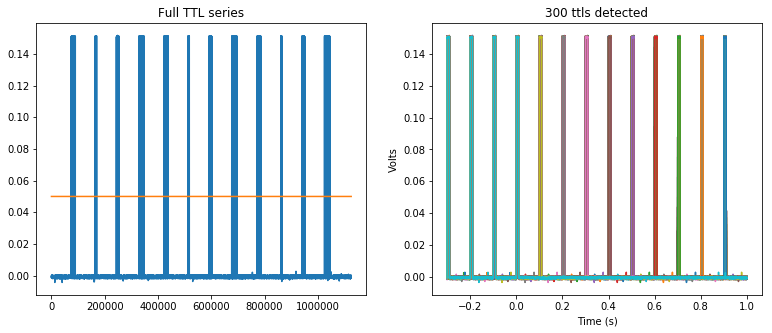

In [7]:
num_files = len(fparams)
if num_files == 0:
    raise Exception("No files to analyze!")
print(str(num_files) + ' files to analyze')

# determine number of cores to use and initialize parallel pool
num_processes = min(mp.cpu_count(), num_files)
print('Total CPU cores for parallel processing: ' + str(num_processes))
pool = mp.Pool(processes=num_processes)

# perform parallel processing; pass iterable list of file params to the analysis module selection code
#pool.map(single_file_process, fparams)

## for testing
for fparam in fparams:
    single_file_process(fparam) 


In [18]:
#### some additional code to load event dictionary to check detected events

fdir = fparams[0]['fdir']
fname = fparams[0]['fname']
eventframe_fname = 'framenumberforevents_{}_1.pkl'.format(fname)

# reload event frame numbers
with open(os.path.join(fdir, eventframe_fname), 'rb') as handle:
        event_frames = pickle.load(handle)
        
len(event_frames['rewards'])

KeyError: 'rewards'